In [20]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Loading data

In [21]:
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Processing Customer Data

In [22]:
def preprocess_customers(customers):
    # Convert SignupDate to days since signup
    customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
    today = pd.Timestamp.today()
    customers['TenureDays'] = (today - customers['SignupDate']).dt.days

    # One-hot encode 'Region'
    customers = pd.get_dummies(customers, columns=['Region'], drop_first=True)
    customers.drop(['SignupDate', 'CustomerName'], axis=1, inplace=True)  # Drop unnecessary columns
    return customers

customers_df = preprocess_customers(customers_df)

# Aggregate Transaction Data

In [23]:
def aggregate_transactions(transactions):
    # Total spend per customer
    total_spend = transactions.groupby('CustomerID')['TotalValue'].sum().rename('TotalSpend')

    # Total transaction count per customer
    transaction_count = transactions.groupby('CustomerID')['TransactionID'].count().rename('TransactionCount')

    # Merge and return
    return pd.concat([total_spend, transaction_count], axis=1).reset_index()

transaction_features = aggregate_transactions(transactions_df)

# Merging Customer and Transaction Data

In [24]:
merged_data = pd.merge(customers_df, transaction_features, on='CustomerID', how='left')
merged_data.fillna(0, inplace=True)  # Handle missing values

# Normalize Data

In [25]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(merged_data.drop('CustomerID', axis=1))

# Applying K means clustering

In [26]:
def perform_clustering(data, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    return kmeans, cluster_labels

kmeans, cluster_labels = perform_clustering(normalized_data, n_clusters=4)
merged_data['Cluster'] = cluster_labels

C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Evaluate Clustering

In [27]:
db_index = davies_bouldin_score(normalized_data, cluster_labels)
silhouette_avg = silhouette_score(normalized_data, cluster_labels)

In [28]:
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")

Davies-Bouldin Index: 1.2466807448049195
Silhouette Score: 0.32167557623100385


# Visualize Clusters (here using PCA i.e Principal Component Analysis for 2D Plot)

In [29]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(normalized_data)
merged_data['PCA1'] = pca_result[:, 0]
merged_data['PCA2'] = pca_result[:, 1]

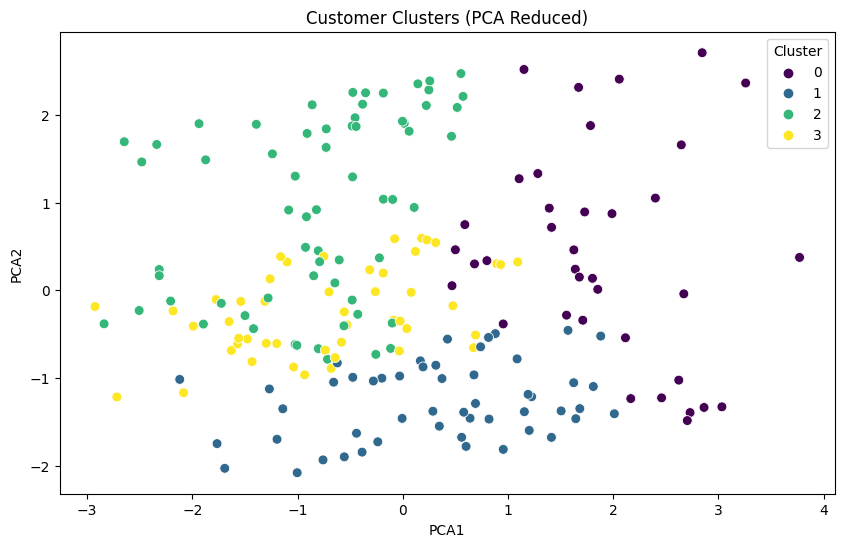

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=merged_data, palette='viridis', s=50
)
plt.title("Customer Clusters (PCA Reduced)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Cluster")
plt.show()

# Generating Insights

In [38]:
def generate_insights(data, cluster_col='Cluster'):
    # Selecting only numeric types
    numeric_cols = data.select_dtypes(include=['number']).columns
    
    # grouping by cluster and calc mean
    cluster_summary = data.groupby(cluster_col).mean(numeric_only=True)
    print("\nCluster Summary Statistics:")
    print(cluster_summary)
    
    return cluster_summary

In [37]:
generate_insights(merged_data)


Cluster Summary Statistics:
         TenureDays  Region_Europe  Region_North America  \
Cluster                                                    
0        623.810811       0.054054              0.243243   
1        593.509804       0.000000              0.000000   
2        478.375000       0.000000              0.578125   
3        574.229167       1.000000              0.000000   

         Region_South America   TotalSpend  TransactionCount      PCA1  \
Cluster                                                                  
0                    0.216216  5908.501622          8.027027  1.884754   
1                    1.000000  3266.155686          4.725490  0.318259   
2                    0.000000  2423.051094          3.859375 -0.807584   
3                    0.000000  3119.412292          4.479167 -0.714202   

             PCA2  
Cluster            
0        0.421303  
1       -1.263713  
2        0.945137  
3       -0.242242  


,TenureDays,Region_Europe,Region_North America,Region_South America,TotalSpend,TransactionCount,PCA1,PCA2
Cluster,,,,,,,,
0,623.810811,0.054054,0.243243,0.216216,5908.501622,8.027027,1.884754,0.421303
1,593.509804,0.000000,0.000000,1.000000,3266.155686,4.725490,0.318259,-1.263713
2,478.375000,0.000000,0.578125,0.000000,2423.051094,3.859375,-0.807584,0.945137
3,574.229167,1.000000,0.000000,0.000000,3119.412292,4.479167,-0.714202,-0.242242
